# Chapter 01 ニューラルネットワークの復習

In [47]:
import numpy as np
import matplotlib.pyplot as plt

### データセットの読み込み

In [48]:
# 今回読み込むデータ
def spiral_data_load(seed=1984):
    np.random.seed(seed)
    N = 100  # クラスごとのサンプル数
    DIM = 2  # データの要素数
    CLS_NUM = 3  # クラス数

    x = np.zeros((N*CLS_NUM, DIM))
    t = np.zeros((N*CLS_NUM, CLS_NUM), dtype=np.int)

    for j in range(CLS_NUM):
        for i in range(N):#N*j, N*(j+1)):
            rate = i / N
            radius = 1.0*rate
            theta = j*4.0 + 4.0*rate + np.random.randn()*0.2

            ix = N*j + i
            x[ix] = np.array([radius*np.sin(theta),
                              radius*np.cos(theta)]).flatten()
            t[ix, j] = 1

    return x, t

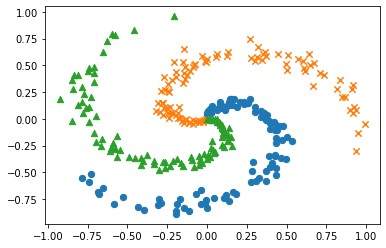

In [49]:
# 実際にプロット
x, t = spiral_data_load()
N = 100
CLS_NUM = 3
markers = ['o', 'x', '^']
for i in range(CLS_NUM):
    plt.scatter(x[i*N:(i+1)*N, 0], x[i*N:(i+1)*N, 1], s=40, marker=markers[i])
plt.show()

### 関数

In [50]:
# softmax関数
def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x


# 交差エントロピー誤差
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

### レイヤ

In [51]:
# Sigmoidレイヤ
class Sigmoid:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None
        
    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx

# 全結合層
class Affine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None
        
    def forward(self, x):
        W, b = self.params
        out = np.dot(x, W) + b
        self.x = x
        return out
    
    def backward(self, dout):
        W, b = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        db = np.sum(dout, axis=0)
        
        self.grads[0][...] = dW
        self.grads[1][...] = db
        return dx

# Matrix Multiply: 行列の積を求めるノード部分
class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None
        
    def forward(self, x):
        W, = self.params
        out = np.dot(x, W)
        self.x = x
        return out

    def backward(self, dout):
        W, = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        self.grads[0][...] = dW
        return dx


# softmaxによって確率を求める
# 交差エントロピーによるlossを求める
class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  # softmaxの出力
        self.t = None  # 教師ラベル

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        # 教師ラベルがone-hotベクトルの場合、正解のインデックスに変換
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size

        return dx

### 最適化アルゴリズム

In [52]:
# Optimizier
class SGD:
    '''
    確率的勾配降下法（Stochastic Gradient Descent）
    '''
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for i in range(len(params)):
            params[i] -= self.lr * grads[i]

### ニューラルネットワーク(実装)

In [53]:
# モデル部分
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size):
        I, H, O = input_size, hidden_size, output_size
        
        # 重みとバイアスの初期化
        W1 = 0.01 * np.random.randn(I, H)
        b1 = np.zeros(H)
        W2 = 0.01 * np.random.randn(H, O)
        b2 = np.zeros(O)
        
        # レイヤ生成
        self.layers = [
            Affine(W1, b1),
            Sigmoid(),
            Affine(W2, b2)
        ]
        
        self.loss_layer = SoftmaxWithLoss()
        
        # 全ての重みをリストにまとめる
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
    
    # 推論
    def predict(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    # 順伝播
    def forward(self, x, t):
        score = self.predict(x)
        loss = self.loss_layer.forward(score, t)
        return loss

    # 逆伝播
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

### ニューラルネットワーク(学習)

In [54]:
# ハイパーパラメータ
max_epoch = 300
batch_size = 30
hidden_size = 10
learning_rate = 1.0

# データの読み込み
x, t = spiral_data_load()

# モデル, optimizerの生成
model = TwoLayerNet(input_size=2, hidden_size=hidden_size, output_size=3)
optimizer = SGD(lr=learning_rate)

# 学習で使用する変数
data_size = len(x)
max_iters = data_size // batch_size
total_loss, loss_count = 0, 0
loss_list = []

for epoch in range(max_epoch):
    # データのシャッフル
    idx = np.random.permutation(data_size)
    x = x[idx]
    t = t[idx]
    
    for iters in range(max_iters):
        batch_x = x[iters*batch_size: (iters+1)*batch_size]
        batch_t = t[iters*batch_size: (iters+1)*batch_size]
        
        
        # 勾配を求めパラメータを更新
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        
        total_loss += loss
        loss_count += 1
        
        # 10イテレーション毎にlossの平均を出力
        # loss平均をloss_listに格納
        if (iters + 1) % 10 == 0:
            avg_loss = total_loss / loss_count
            print('| epoch %d | iter %d/%d | loss %.2f |'
                  % (epoch + 1, iters + 1, max_iters, avg_loss))
            loss_list.append(avg_loss)
            total_loss, loss_count = 0, 0

| epoch 1 | iter 10/10 | loss 1.13 |
| epoch 2 | iter 10/10 | loss 1.13 |
| epoch 3 | iter 10/10 | loss 1.12 |
| epoch 4 | iter 10/10 | loss 1.12 |
| epoch 5 | iter 10/10 | loss 1.11 |
| epoch 6 | iter 10/10 | loss 1.14 |
| epoch 7 | iter 10/10 | loss 1.16 |
| epoch 8 | iter 10/10 | loss 1.11 |
| epoch 9 | iter 10/10 | loss 1.12 |
| epoch 10 | iter 10/10 | loss 1.13 |
| epoch 11 | iter 10/10 | loss 1.12 |
| epoch 12 | iter 10/10 | loss 1.11 |
| epoch 13 | iter 10/10 | loss 1.09 |
| epoch 14 | iter 10/10 | loss 1.08 |
| epoch 15 | iter 10/10 | loss 1.04 |
| epoch 16 | iter 10/10 | loss 1.03 |
| epoch 17 | iter 10/10 | loss 0.96 |
| epoch 18 | iter 10/10 | loss 0.92 |
| epoch 19 | iter 10/10 | loss 0.92 |
| epoch 20 | iter 10/10 | loss 0.87 |
| epoch 21 | iter 10/10 | loss 0.85 |
| epoch 22 | iter 10/10 | loss 0.82 |
| epoch 23 | iter 10/10 | loss 0.79 |
| epoch 24 | iter 10/10 | loss 0.78 |
| epoch 25 | iter 10/10 | loss 0.82 |
| epoch 26 | iter 10/10 | loss 0.78 |
| epoch 27 | iter 10/

| epoch 227 | iter 10/10 | loss 0.14 |
| epoch 228 | iter 10/10 | loss 0.14 |
| epoch 229 | iter 10/10 | loss 0.13 |
| epoch 230 | iter 10/10 | loss 0.14 |
| epoch 231 | iter 10/10 | loss 0.13 |
| epoch 232 | iter 10/10 | loss 0.14 |
| epoch 233 | iter 10/10 | loss 0.13 |
| epoch 234 | iter 10/10 | loss 0.13 |
| epoch 235 | iter 10/10 | loss 0.13 |
| epoch 236 | iter 10/10 | loss 0.13 |
| epoch 237 | iter 10/10 | loss 0.14 |
| epoch 238 | iter 10/10 | loss 0.13 |
| epoch 239 | iter 10/10 | loss 0.13 |
| epoch 240 | iter 10/10 | loss 0.14 |
| epoch 241 | iter 10/10 | loss 0.13 |
| epoch 242 | iter 10/10 | loss 0.13 |
| epoch 243 | iter 10/10 | loss 0.13 |
| epoch 244 | iter 10/10 | loss 0.13 |
| epoch 245 | iter 10/10 | loss 0.13 |
| epoch 246 | iter 10/10 | loss 0.13 |
| epoch 247 | iter 10/10 | loss 0.13 |
| epoch 248 | iter 10/10 | loss 0.13 |
| epoch 249 | iter 10/10 | loss 0.13 |
| epoch 250 | iter 10/10 | loss 0.13 |
| epoch 251 | iter 10/10 | loss 0.13 |
| epoch 252 | iter 10/10 

### 学習結果

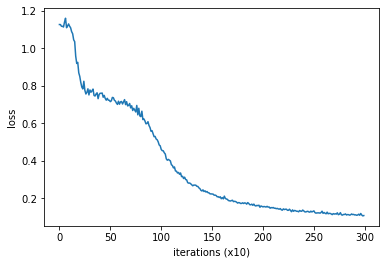

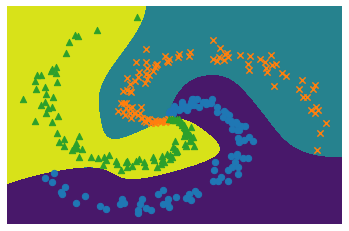

In [55]:
# 学習結果のプロット
plt.plot(np.arange(len(loss_list)), loss_list, label='train')
plt.xlabel('iterations (x10)')
plt.ylabel('loss')
plt.show()

# 境界領域のプロット
h = 0.001
x_min, x_max = x[:, 0].min() - .1, x[:, 0].max() + .1
y_min, y_max = x[:, 1].min() - .1, x[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
X = np.c_[xx.ravel(), yy.ravel()]
score = model.predict(X)
predict_cls = np.argmax(score, axis=1)
Z = predict_cls.reshape(xx.shape)
plt.contourf(xx, yy, Z)
plt.axis('off')

# データ点のプロット
x, t = spiral_data_load()
N = 100
CLS_NUM = 3
markers = ['o', 'x', '^']
for i in range(CLS_NUM):
    plt.scatter(x[i*N:(i+1)*N, 0], x[i*N:(i+1)*N, 1], s=40, marker=markers[i])
plt.show()